In [1]:
include("speciale_tools.jl")
import JLD
import PyPlot

In [2]:
data_folder = "/Users/simon/Documents/DTU fag/Speciale/houston_new"
VV_files,VH_files,coherence_VV_files,coherence_VH_files = _sort_prossed_files(data_folder);

In [3]:
VV = _load_jld(VV_files[[1,3]],data_folder);
VH = _load_jld(VH_files[[1,3]],data_folder);

In [4]:
threshold_indx =3

3

## VV

In [5]:
co = VV[1][:,end:-1:1]
pre = VV[2][:,end:-1:1];

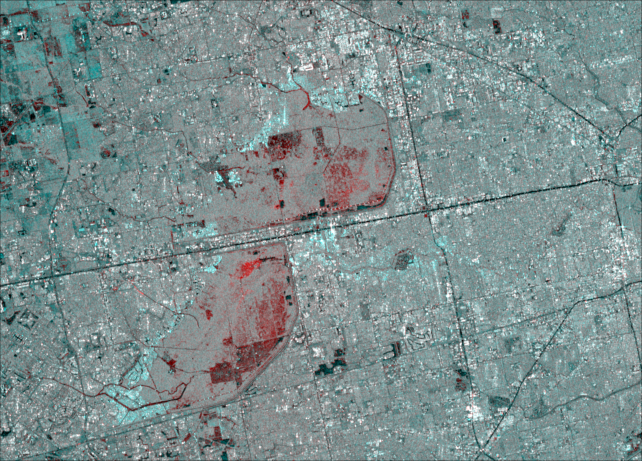

In [6]:
imgVV = pretty_img([co,pre],min_vv,max_vv)

In [7]:
flood_band = 10 .*log10.(co);
ref_band = 10 .*log10.(pre);
change_band = flood_band .- ref_band;

In [8]:
# Find the tiles to fit bimodal
bm_mask_flood = find_bimodal_tiles(flood_band);
bm_mask_change = find_bimodal_tiles(change_band);
bm_mask = bm_mask_change.&bm_mask_flood;


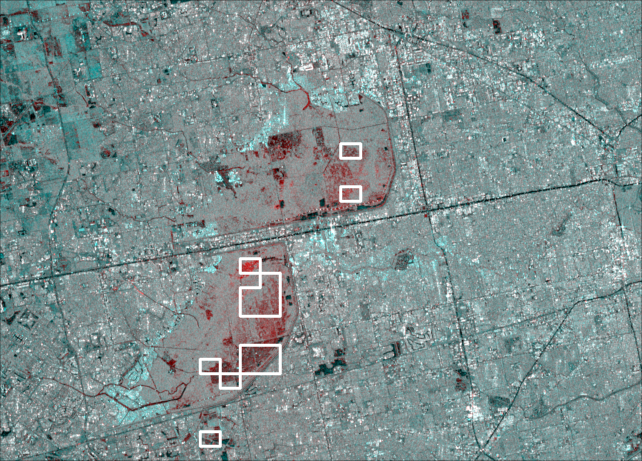

In [9]:
subset_edges = get_edges(bm_mask);
add_mask(imgVV,subset_edges,(1,1,1))

In [10]:
# fit bimodel
data = reshape(flood_band,:)[reshape(bm_mask,:)]
p_fit,y,w,edges, w_sum = fit_bimodal_gauss(data,round(Int64,length(data)/50))

# Find seed pixels
y_seed =find_y_seed(p_fit,y)
seed_mask = flood_band .<y_seed;



In [11]:
t_0 = [y_seed+1, -1]
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, t), 
    t_0; autodiff = :forward,store_trace = true,trace_simplex=true)
thresholds1 = res.minimizer
f1 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds1)
thresholds1, f1

([4.32786, -2.00677], 0.00011096120815747706)

In [12]:
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [t,10]),
    y_seed, p_fit[4])

y_RG = res.minimizer
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [y_RG,t]),
    -5, 2)
thresholds2 = [y_RG, res.minimizer]
f2 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds2)
thresholds2, f2

([-11.3404, -0.871393], 0.00021548433685793358)

In [13]:
t_0 = [y_seed+1, -1]
thresholds3, n_iter = grad_decent(
            (t1,t2) -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [t1,t2])
            ,t_0)
f3 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds3)
thresholds3, f3


Iterration : 1
dfdx: [0.0, 0.0], f_i: 0.0006088503793745047
No gradiant increase delta, no_step: -4

Iterration : 2
dfdx: [-0.000498796, 0.0], f_i: 0.0006088503793745047
Step x, no_step: -4

Iterration : 3
dfdx: [0.0, 0.00145347], f_i: 0.00035827596346440724
Step x, no_step: 0

Iterration : 4
dfdx: [0.0, -0.000319507], f_i: 0.00016233114049074156
Step x, no_step: 0

Iterration : 5
dfdx: [0.0, -5.80595e-5], f_i: 0.00011930942536154218
No gradiant increase delta, no_step: 1

Iterration : 6
dfdx: [-5.13451e-7, -0.00014906], f_i: 0.00011930942536154218
Step x, no_step: 1

Iterration : 7
dfdx: [-5.13451e-7, 2.7152e-5], f_i: 0.00011113937928419808
No gradiant increase delta, no_step: 1

Iterration : 8
dfdx: [-5.13451e-8, -8.34738e-6], f_i: 0.00011113937928419808
No gradiant increase delta, no_step: 2

Iterration : 9
dfdx: [-1.01524e-7, 3.05739e-5], f_i: 0.00011113937928419808
No gradiant increase delta, no_step: 3


([-7.46153, -1.9849], 0.00011113937928419808)

In [14]:
rg_thresholds = [thresholds1,thresholds2,thresholds3][threshold_indx]

2-element Array{Float64,1}:
 -7.4615265050274475
 -1.984899861261476 

In [ ]:
#y_seed =-15
rg_thresholds = [-20,-1.5]
seed_mask = flood_band .< y_seed;
y_seed

In [15]:
rg_mask = (flood_band .<rg_thresholds[1]) .& (change_band.<rg_thresholds[2]) .| seed_mask 
flood_mask, steps = region_growing(seed_mask,rg_mask);

In [16]:
# select the water pixelss in the selected tiles
data = reshape(flood_band,:)[reshape(rg_mask.&bm_mask,:)];
    
# Compare histogram with the emepircal in p_water
h = StatsBase.fit(StatsBase.Histogram, data,edges)
w_sel = h.weights./w_sum;

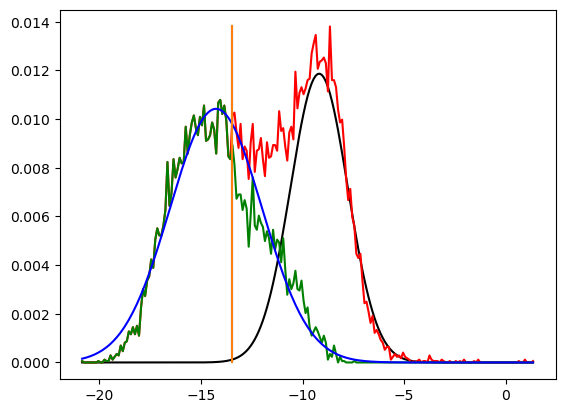

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1410a45f8>

In [17]:

PyPlot.figure()

PyPlot.plot(y,gauss_model(y,p_fit[[2,4,6]]),color="k")
PyPlot.plot(y,w,color="r")
#PyPlot.plot(y, bimodal_gauss_model(y, p_fit) )
PyPlot.plot(y,w_sel,color="g")
PyPlot.plot(y,gauss_model(y,p_fit[[1,3,5]]),color="b")
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w),maximum(w),8))
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w),maximum(w),8))

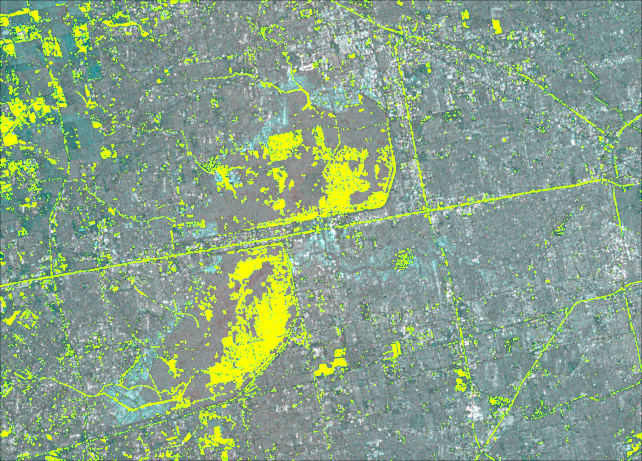

In [18]:
add_mask(imgVV,flood_mask,(1,2,0))

In [19]:
rg_thresholds

2-element Array{Float64,1}:
 -7.4615265050274475
 -1.984899861261476 

In [20]:
seed_mask_ref = ref_band .<y_seed
rg_mask_ref = (ref_band .<rg_thresholds[1])
ref_mask, steps = region_growing(seed_mask_ref,rg_mask_ref);
    
# Remove flase positives and permant water.
final_mask = flood_mask .& (ref_mask .!=true);

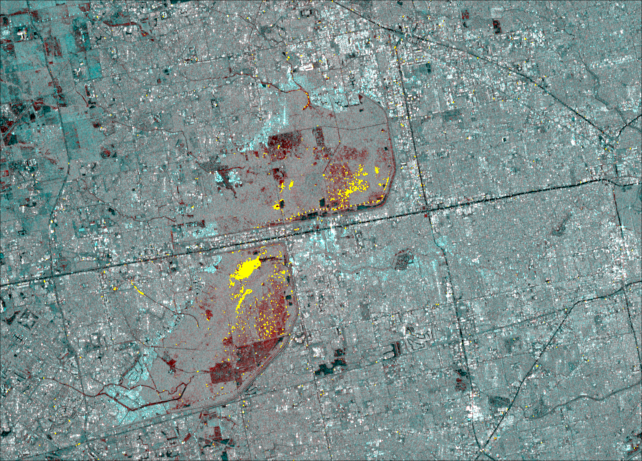

In [21]:
add_mask(imgVV,final_mask,(1,1,0))

In [ ]:
file_path = joinpath(data_folder,"VVhand_tuned_mask")
JLD.save(file_path*".jld", "data", final_mask)

## VH

In [23]:
co = VH[1][:,end:-1:1]
pre = VH[2][:,end:-1:1];

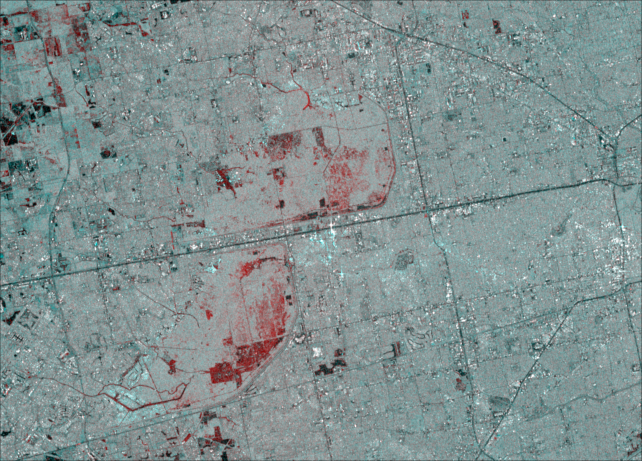

In [24]:
imgVH = pretty_img([co,pre],min_vh,max_vh)

In [25]:
flood_band = 10 .*log10.(co);
ref_band = 10 .*log10.(pre);
change_band = flood_band .- ref_band;

In [26]:
# Find the tiles to fit bimodal
bm_mask_flood = find_bimodal_tiles(flood_band);
bm_mask_change = find_bimodal_tiles(change_band);
bm_mask = bm_mask_change.&bm_mask_flood;


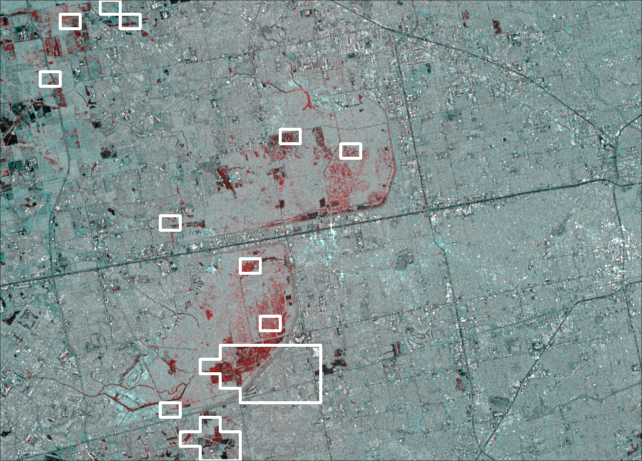

In [27]:
subset_edges = get_edges(bm_mask);
add_mask(imgVH,subset_edges,(1,1,1))

In [28]:
# fit bimodel
data = reshape(flood_band,:)[reshape(bm_mask,:)]
p_fit,y,w,edges, w_sum = fit_bimodal_gauss(data,round(Int64,length(data)/50))

# Find seed pixels
y_seed =find_y_seed(p_fit,y)
seed_mask = flood_band .<y_seed;

In [29]:
t_0 = [y_seed+1, -1]
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, t), 
    t_0; autodiff = :forward,store_trace = true,trace_simplex=true)
thresholds1 = res.minimizer
f1 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds1)
thresholds1, f1

([18.5863, -1.97969], 4.7507052785984525e-5)

In [30]:
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [t,10]),
    y_seed, p_fit[4])

y_RG = res.minimizer
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [y_RG,t]),
    -5, 2)
thresholds2 = [y_RG, res.minimizer]
f2 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds2)
thresholds2, f2

([-19.3269, -0.101622], 5.923187142365202e-5)

In [32]:
t_0 = [y_seed+1, -1]
thresholds3, n_iter = grad_decent(
            (t1,t2) -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [t1,t2])
            ,t_0)
f3 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds3)
thresholds3, f3


Iterration : 1
dfdx: [0.0, 0.0], f_i: 0.00016766116938582692
No gradiant increase delta, no_step: -4

Iterration : 2
dfdx: [-9.79307e-5, 0.0], f_i: 0.00016766116938582692
Step x, no_step: -4

Iterration : 3
dfdx: [-0.000107927, -5.90202e-6], f_i: 9.394420949626516e-5
Step x, no_step: 0

Iterration : 4
dfdx: [7.44856e-6, -5.32514e-6], f_i: 5.269721525750044e-5
Step x, no_step: 0

Iterration : 5
dfdx: [2.78272e-6, 1.77227e-6], f_i: 5.261537159415621e-5
Step x, no_step: 0

Iterration : 6
dfdx: [-1.24702e-5, 2.32661e-5], f_i: 5.25751164474003e-5
Step x, no_step: 0

Iterration : 7
dfdx: [3.7736e-5, 8.24217e-6], f_i: 5.146904447414488e-5
Step x, no_step: 0

Iterration : 8
dfdx: [-1.02642e-5, 0.0], f_i: 5.109432743626088e-5
Step x, no_step: 0

Iterration : 9
dfdx: [0.0, 0.0], f_i: 5.04304888509112e-5
No gradiant increase delta, no_step: 1

Iterration : 10
dfdx: [-3.72202e-5, 3.2104e-6], f_i: 5.04304888509112e-5
Step x, no_step: 1

Iterration : 11
dfdx: [1.77957e-5, 9.88302e-6], f_i: 4.618532

([-18.2315, -1.22189], 4.5539673501959876e-5)

In [ ]:
#y_seed =-15
rg_thresholds = [-20,-1.5]
seed_mask = flood_band .< y_seed;
y_seed

In [41]:
rg_thresholds = [thresholds1,thresholds2,thresholds3][threshold_indx]

2-element Array{Float64,1}:
 -18.23147425869684  
  -1.2218942720259953

In [42]:
rg_mask = (flood_band .<rg_thresholds[1]) .& (change_band.<rg_thresholds[2]) .| seed_mask 
flood_mask, steps = region_growing(seed_mask,rg_mask);

In [43]:
# select the water pixelss in the selected tiles
data = reshape(flood_band,:)[reshape(rg_mask.&bm_mask,:)];
    
# Compare histogram with the emepircal in p_water
h = StatsBase.fit(StatsBase.Histogram, data,edges)
w_sel = h.weights./w_sum;

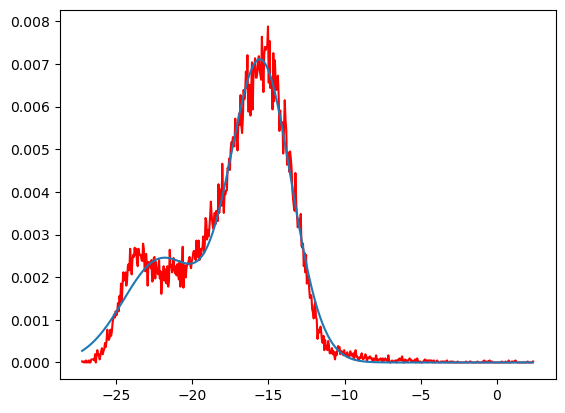

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x141762e48>

In [44]:
PyPlot.figure()
PyPlot.plot(y,w,color="r")
PyPlot.plot(y, bimodal_gauss_model(y, p_fit) )


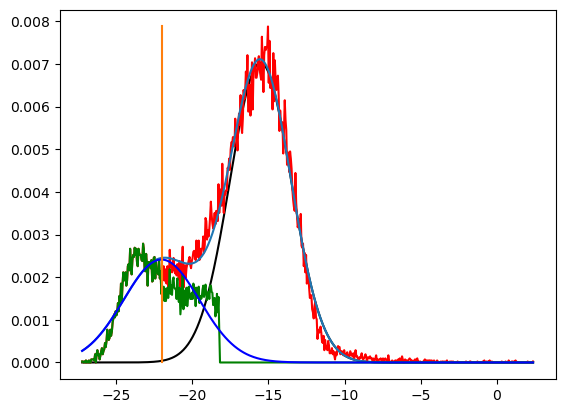

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x141770400>

In [45]:

PyPlot.figure()

PyPlot.plot(y,gauss_model(y,p_fit[[2,4,6]]),color="k")
PyPlot.plot(y,w,color="r")
PyPlot.plot(y, bimodal_gauss_model(y, p_fit) )
PyPlot.plot(y,w_sel,color="g")
PyPlot.plot(y,gauss_model(y,p_fit[[1,3,5]]),color="b")
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w),maximum(w),8))

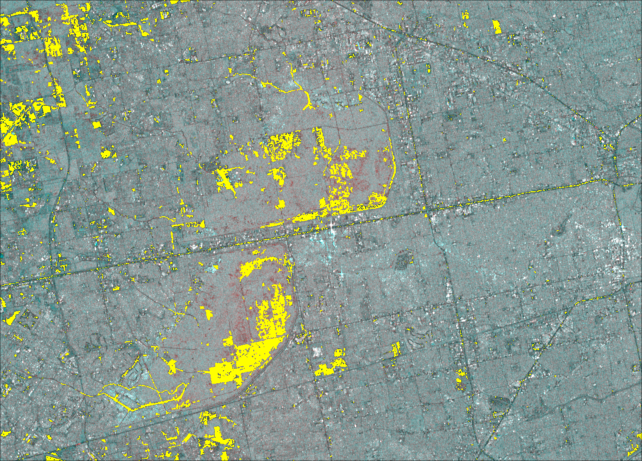

In [46]:
add_mask(imgVH,flood_mask,(1,1,0))

In [47]:
seed_mask_ref = ref_band .<y_seed
rg_mask_ref = (ref_band .<rg_thresholds[1])
ref_mask, steps = region_growing(seed_mask_ref,rg_mask_ref);
    
# Remove flase positives and permant water.
final_mask = flood_mask .& (ref_mask .!=true);

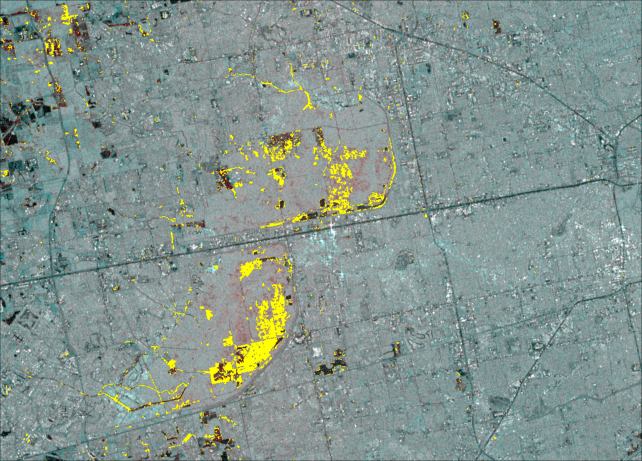

In [48]:
add_mask(imgVH,final_mask,(1,1,0))

In [ ]:
file_path = joinpath(data_folder,"VHhand_tuned_mask")
JLD.save(file_path*".jld", "data", final_mask)